In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#<font color='orange'>Basics</font>

In [135]:
seeds = [120054, 388388, 570334, 907360, 938870]
percent_bads = [0.7, 0.8, 0.9, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.36, 0.4]
sizes = [1000, 5000, 10000]
contaminations = [0.12, ]#0.13, 0.14, 0.15, 0.16, 0.18, 0.2, ]#0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4]

len(seeds)*len(percent_bads)*len(sizes)*len(contaminations)#*12/1024#*2/60

285

In [136]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [138]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [140]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns

In [ ]:
To list the contents of a directory and show the sum of file sizes within subfolders, you can use the following command in the terminal:

```bash
du -sh ../data/riData/Models/TN-2009/*
```

This command will provide a summary of the disk usage of each subfolder in a human-readable format.

In [2]:
ls -l -h ../data/riData/Models/TN-2009/

total 20K
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 25 15:45 120054/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 16:30 388388/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 17:51 570334/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 19:16 907360/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 20:32 938870/


In [142]:
!find ../data/riData/Models -type f | wc -l

411


In [143]:
seeds = [120054, 388388, 570334, 907360, 938870]

file_init = pd.DataFrame()

for seed_number in seeds:
    folder = os.path.join(ri_datasets_path,f'Data/TN-{year}/{seed_number}/')
    print(f'there are {len(os.listdir(folder))} files in {folder}')

    for file in os.listdir(folder):
        if file_init.shape == (0,0):
            file_init = pd.read_parquet(os.path.join(folder, file))
        filename = os.path.join(folder, file)
        try:
            pd.read_parquet(filename).shape == file_init.shape
        except Exception as e:
            print(f'Error in {filename}: {e}')
    print(file_init.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../data/riData/Data/TN-2010/120054/'

In [ ]:
pd.DataFrame().shape


(0, 0)

In [ ]:
seeds = [120054, 388388, 570334, 907360, 938870]
percent_bads = [0.07, 0.08, 0.09, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.36, 0.4]
sizes = [1000, 5000, 10000]

In [ ]:
print(len(percent_bads)*len(sizes))

57


In [ ]:
seed_number = 388389
year = 2010
size = 1000
p_value = 0.07
contamination_threshold = 0.12

params_dict = {'seed_number': seed_number,
                    'year': year,
                    'size': size,
                    'p_value': p_value,
                    'contamination_threshold': contamination_threshold}

In [ ]:
datapath_ex = os.path.join(ri_datasets_path,f'Data/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet')

In [ ]:
data_ex = pd.read_parquet(datapath_ex)

In [ ]:
data_ex

,first_it,label
index,,
125997,-1,-1
164853,-1,-1
164864,-1,-1
131555,-1,-1
164884,-1,-1
...,...,...
129465,50,0
110058,50,0
146731,50,0


In [ ]:
os.path.join(ri_datasets_path,f'Data/Load/{seed_number}_{year}')

'../data/riData/Data/Load/388389_2010'

In [ ]:
ls '../data/riData/Load'

120054_2009/  388389_2010/  907360_2009/
388388_2009/  570334_2009/  938870_2009/


In [ ]:
data_ex.loc[data_ex.first_it == 0,'label']

index
1643179    0
1643596    0
1643176    0
1643180    1
1643181    0
          ..
1642609    0
1639314    0
1641811    0
1639329    0
1641920    0
Name: label, Length: 6122, dtype: int64

In [ ]:
load_path = os.path.join(ri_datasets_path, f'Load/{seed_number}_{year}')

if Path(f'{load_path}').exists():# and False:
        df_train = pd.read_csv(f'{load_path}/A_train.csv', index_col=0)
        df_val = pd.read_csv(f'{load_path}/A_val.csv', index_col=0)
        df_test = pd.read_csv(f'{load_path}/A_test.csv', index_col=0)
        R_train = pd.read_csv(f'{load_path}/R_train.csv', index_col=0)
        R_val = pd.read_csv(f'{load_path}/R_val.csv', index_col=0)
        R_test = pd.read_csv(f'{load_path}/R_test.csv', index_col=0)
        X_train = df_train.loc[:, df_train.columns != "target"]
        y_train = df_train["target"]
        X_val = df_val.loc[:, df_val.columns != "target"]
        y_val = df_val["target"]
        X_test = df_test.loc[:, df_test.columns != "target"]
        y_test = df_test["target"]

In [ ]:
# def decode_parquet(seed_number = 120054, year = 2009, size = 1000,
#         p_value = 0.07, contamination_threshold = 0.12, iteration = 1):
iteration = 50

datapath_ex = os.path.join(ri_datasets_path, f'Data/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet')

parquet_df = pd.read_parquet(datapath_ex)

train_i = parquet_df.loc[(data_ex.first_it <= iteration) & (data_ex.first_it >=0) ,:]
first_added = R_train.loc[R_train.index.intersection(train_i.index),:]
# first_added = pd.concat([first_added, train_i], axis=1)

not_added = parquet_df.loc[(data_ex.first_it==-1) ,:]
df_left = R_train.loc[R_train.index.intersection(not_added.index),:]


df_i = pd.concat([X_train, first_added], axis=0)
df_i = pd.concat([df_i, train_i], axis=1)

assert df_i.shape[0] == (X_train.shape[0] + first_added.shape[0])

#avoid

In [19]:
# train_list = [pd.DataFrame({**item, 'group': i}) for i, item in enumerate(data_ex['X'])]
# left = data_ex['unl'][-1]
# left['group'] = -1

# df = pd.concat(train_list, axis=0, ignore_index=False)
# df = pd.concat([df, left])

# min_values = df.group.groupby(level=0).min()
# last_value = data_ex['y'][-1]

# result_df = pd.DataFrame({
#     'first_it': min_values,
#     'label': last_value
# }, index=min_values.index)
# result_df = result_df.sort_values(by=['first_it'], ascending=True)
# result_df.fillna(-1, inplace=True)
# result_df = result_df.astype(int)

# result_df.to_csv(os.path.join(ri_datasets_path, f'Data/TN-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.csv'))
# result_df.to_parquet(os.path.join(ri_datasets_path, f'Data/TN-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.parquet'))

In [129]:
X = df_i.loc[:, ~df_i.columns.isin(['first_it', 'label'])]

# Standardize the selected columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the standardized result back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

df_scaled = pd.concat([X_scaled_df, df_i.loc[:, ['first_it', 'label']]], axis=1)
df_scaled


,emp_length,addr_state,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util,first_it,label
1651966,-0.400047,0.197029,-0.043815,0.441379,0.002162,1.686972,-0.387695,-0.477315,2.406626,2.571062,-2.025099,1.760519,0,1
1642601,-0.400047,-0.280395,-0.042562,-0.374683,0.873323,-2.278402,-0.387695,0.570511,-0.199427,-0.675238,1.791274,-2.195119,0,0
1643153,0.195863,0.329404,-0.041958,0.421475,0.406629,0.106785,-0.387695,0.177576,-1.068112,-0.675238,-2.025099,1.578498,0,0
1643380,2.281548,-1.239176,-0.043703,0.520995,0.562194,-0.055067,-0.387695,0.570511,-1.068112,-0.675238,2.617689,1.369839,0,0
1644529,1.685638,0.329404,-0.044536,-0.573723,1.028887,-0.953771,-0.387695,-0.542804,1.537942,-0.675238,1.791274,-1.435956,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156285,0.344840,-0.309921,-0.040664,-0.971802,-0.315190,0.843638,-0.387695,-0.305472,0.669257,-0.675238,-0.026669,0.284369,24,0
105789,1.238705,-0.665502,-0.040239,-0.076124,0.512413,-0.108308,1.181231,-0.113851,-0.633770,-0.675238,-0.026669,-0.705650,3,0
121329,0.195863,-0.477239,-0.044035,1.416673,0.947994,-0.319141,-0.387695,0.586883,-0.633770,0.947912,-0.026669,-0.849936,8,0
104067,0.195863,0.329404,-0.042522,0.720035,0.736426,-0.289326,1.181231,0.690356,-1.068112,-0.675238,-0.026669,0.588478,25,0


In [130]:
pca = PCA(n_components=2, random_state = seed_number)  # Reduce to 2 dimensions for visualization
principalComponents = pca.fit_transform(X_scaled)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['Pc1', 'Pc2'], index=df_scaled.index)

# Add the group information back for plotting
finalDf = pd.concat([principalDf, df_i.loc[:, ['first_it', 'label']]], axis = 1)


In [131]:
finalDf.first_it.unique()

array([ 0, 39, 18, 25, 23, 31, 15, 13,  1,  9, 14,  8, 46, 42, 22, 20, 26,
       33,  3, 17,  2, 40, 44, 24, 35, 47,  5, 37, 41, 30,  4, 43, 29,  6,
       38, 36,  7, 10, 11, 19, 27, 21, 12, 34, 32, 48, 45, 28, 16])

In [132]:
finalDf.loc[finalDf['first_it'] == 0]

,Pc1,Pc2,first_it,label
1651966,3.277973,-1.034987,0,1
1642601,-2.890198,1.149283,0,0
1643153,0.609645,0.492648,0,0
1643380,0.542768,1.345785,0,0
1644529,-1.767462,0.812707,0,0
...,...,...,...,...
1642892,-0.388945,1.916740,0,0
1640011,0.455463,0.824199,0,0
1638667,0.931127,2.831069,0,0
1641266,-0.733410,-0.930835,0,0


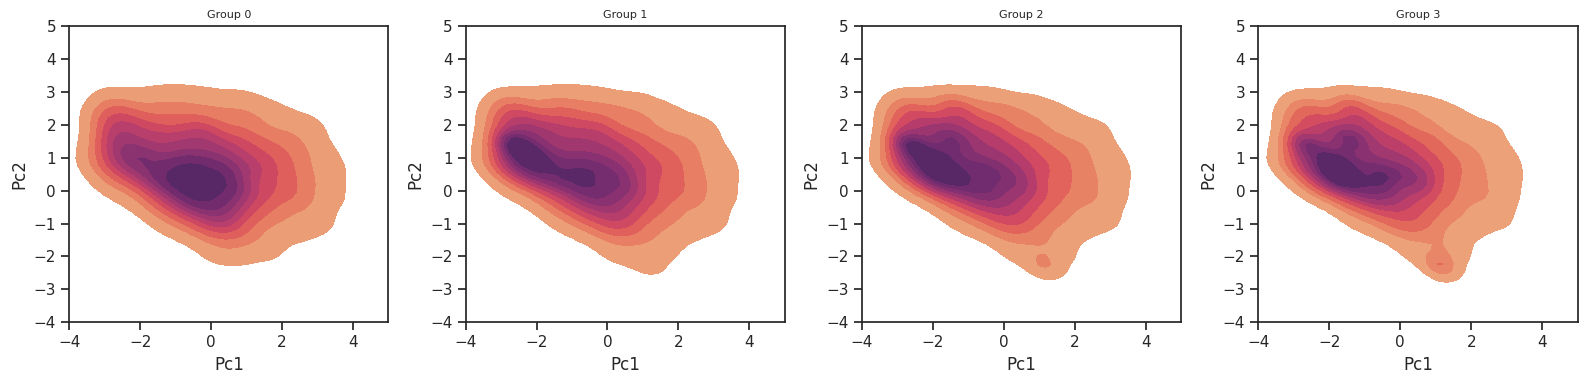

In [133]:
import math

# Define N as the total number of groups you want to plot
N = 5 #finalDf['first_it'].max()  # Number of unique first_its

# Calculate the number of rows and columns needed for the grid
n_cols = 5  # You can adjust this to your preference
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# For each first_it, create a KDE plot
for i in range(0, 5):  # Loop through the number of unique first_its
    ax = axs[i]
    sns.kdeplot(
        x="Pc1", y="Pc2", 
        data=finalDf.query(f"first_it <= {i} and label != 9999"),
        cmap="flare", fill=True, ax=ax
    )
    # sns.kdeplot(
    #     x="Pc1", y="Pc2", 
    #     data=finalDf.query(f"first_it <= {i} and label == 1"),
    #     cmap="Blues", fill=True, ax=ax
    # )
    ax.set_title(f'Group {i}', fontsize=8)
    ax.set_ylim([-4, 5])
    ax.set_xlim([-4, 5])

# Turn off the axes for any remaining empty subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
plt.show()


In [156]:
it_mean = {}
for it in range(df_i.first_it.max()):
    cols_mean = {}
    df_it  = df_i.loc[(df_i.first_it <= it) & (df_i.first_it >= 0),:]
    for c in df_i.columns:
        cols_mean[c] = df_it.loc[:,c].mean()
    it_mean[it] = cols_mean

In [162]:
mean_df = pd.DataFrame(it_mean).drop(['addr_state', 'term', 'first_it']).T
mean_df

,emp_length,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,home_ownership,revol_util,label
0,4.908282,13.053928,10423.440052,684.759229,12.278685,0.146031,69280.201121,1.181313,0.140756,48.081940,0.141294
1,4.592881,125.440598,10556.799635,692.726411,11.947787,0.133460,70378.007789,1.126720,0.140543,45.081962,0.131283
2,4.300234,137.237442,10765.856809,697.135311,11.794895,0.127432,70661.366470,1.112041,0.140383,43.685654,0.123738
3,4.100362,432.386290,10971.223404,698.348334,11.798668,0.125630,70850.300496,1.096470,0.140258,43.560791,0.117847
4,3.924521,455.801684,10949.432117,696.855710,11.828824,0.128038,69976.004362,1.093509,0.140157,44.056208,0.113120
5,3.796260,471.887001,11103.044137,694.065276,11.887652,0.124663,69808.041679,1.101690,0.140075,44.913837,0.109243
6,3.638632,477.257095,11210.581341,691.221787,11.955887,0.121473,69801.754948,1.104521,0.140006,46.201269,0.106006
7,3.517071,490.779717,11380.136185,688.568054,12.030191,0.121590,69894.408825,1.095679,0.139948,47.182225,0.103262
8,3.390667,458.797856,11789.984565,687.719941,12.112379,0.116237,70258.425334,1.074458,0.139898,47.618362,0.100906
9,3.344465,435.137259,12152.307897,686.260316,12.177170,0.112485,70720.319717,1.064112,0.139854,47.954752,0.098863


AttributeError: module 'seaborn' has no attribute 'plot'

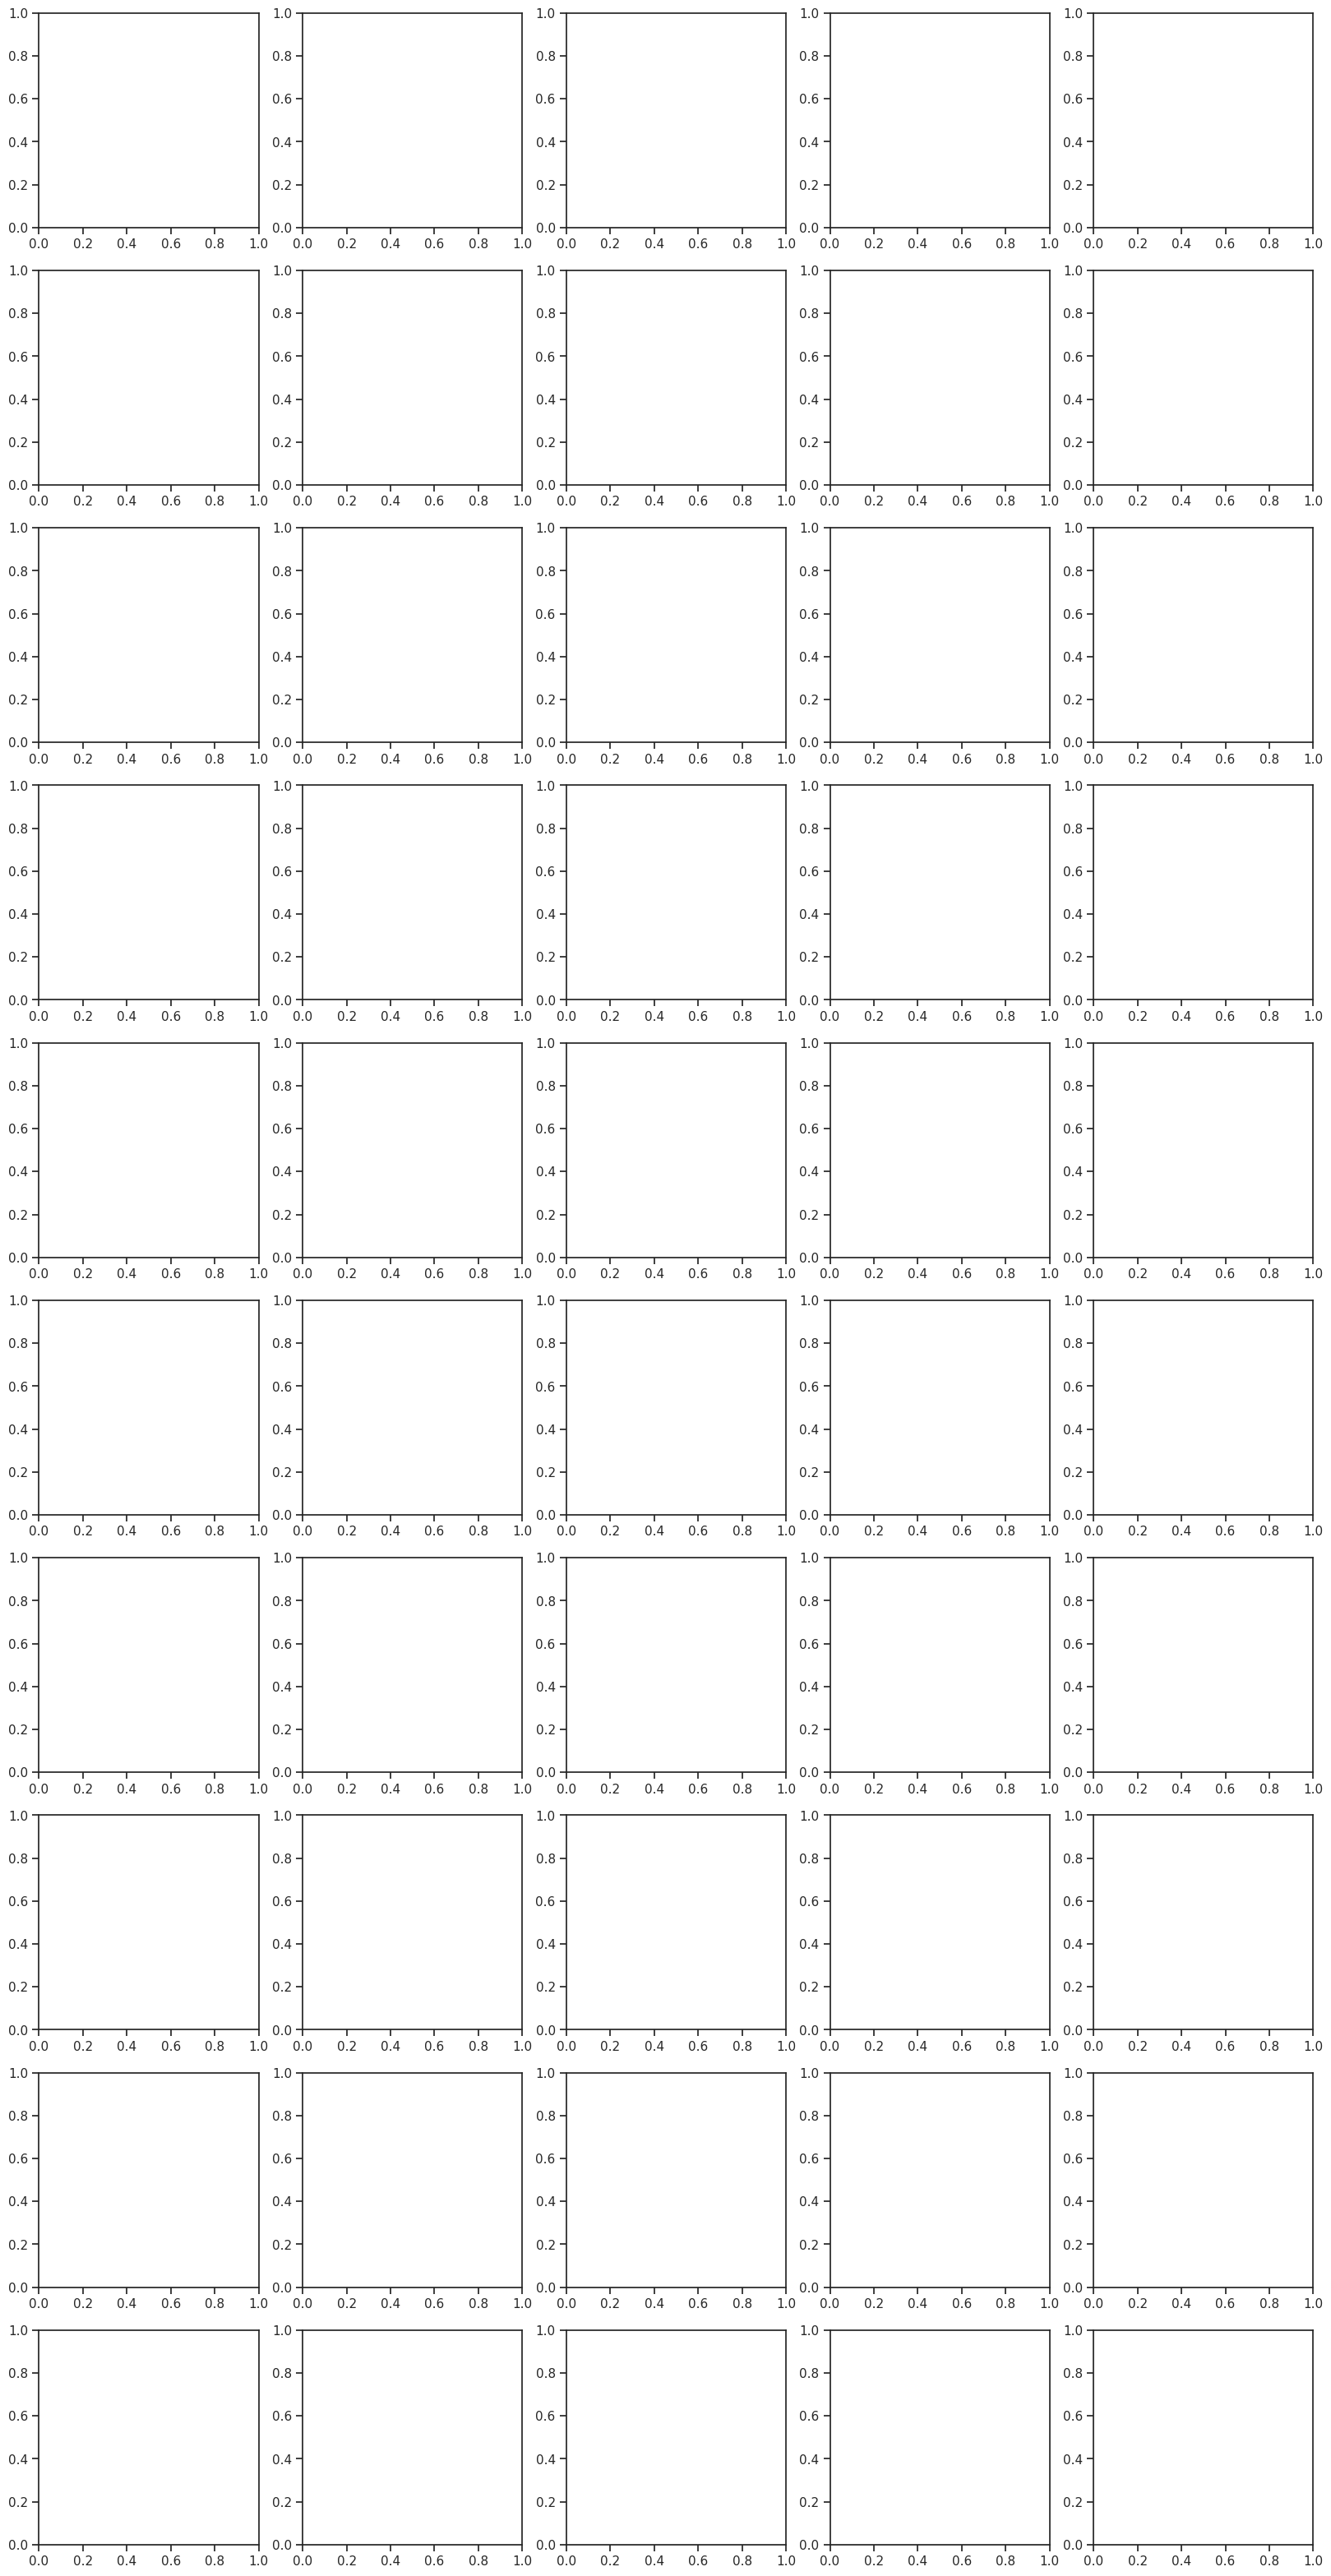

In [164]:
import math

# Define N as the total number of groups you want to plot
N = finalDf['first_it'].max()  # Number of unique first_its

# Calculate the number of rows and columns needed for the grid
n_cols = 5  # You can adjust this to your preference
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# For each first_it, create a KDE plot
for i in range(0, 5):  # Loop through the number of unique first_its
    ax = axs[i]
    sns.plot(
        x="Pc1", y="Pc2", 
        data=finalDf.query(f"first_it <= {i} and label != 9999"),
        cmap="flare", fill=True, ax=ax
    )
    # sns.kdeplot(
    #     x="Pc1", y="Pc2", 
    #     data=finalDf.query(f"first_it <= {i} and label == 1"),
    #     cmap="Blues", fill=True, ax=ax
    # )
    ax.set_title(f'Group {i}', fontsize=8)
    ax.set_ylim([-4, 5])
    ax.set_xlim([-4, 5])

# Turn off the axes for any remaining empty subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
plt.show()


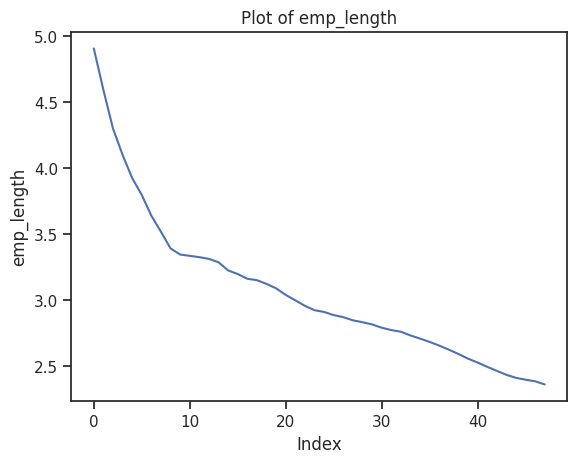

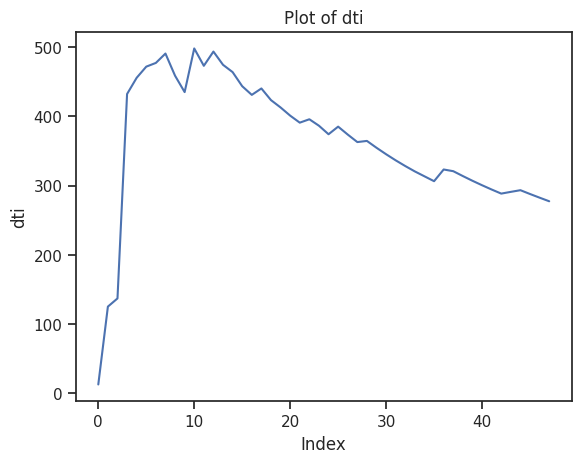

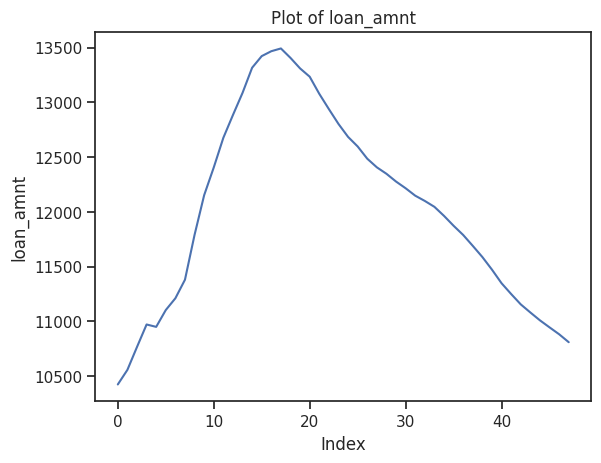

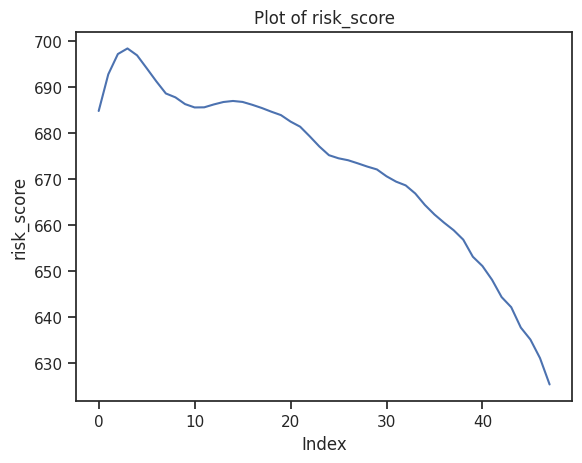

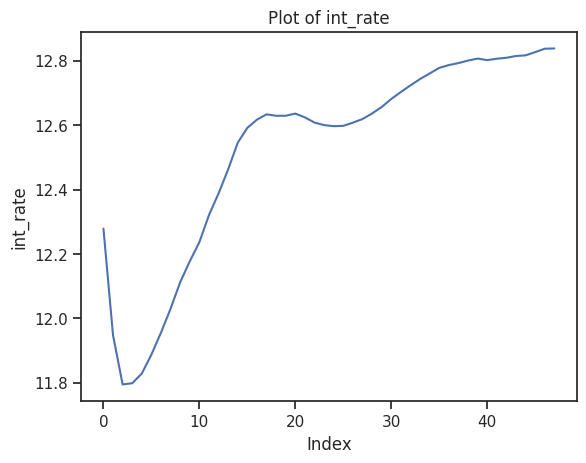

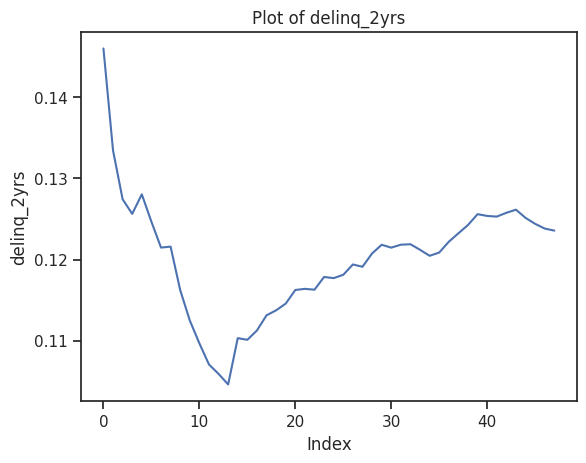

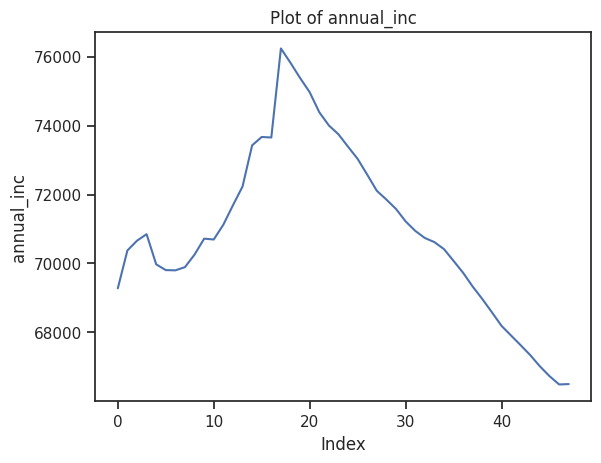

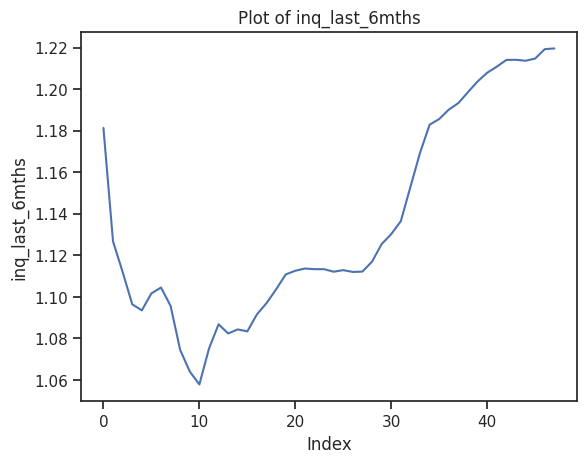

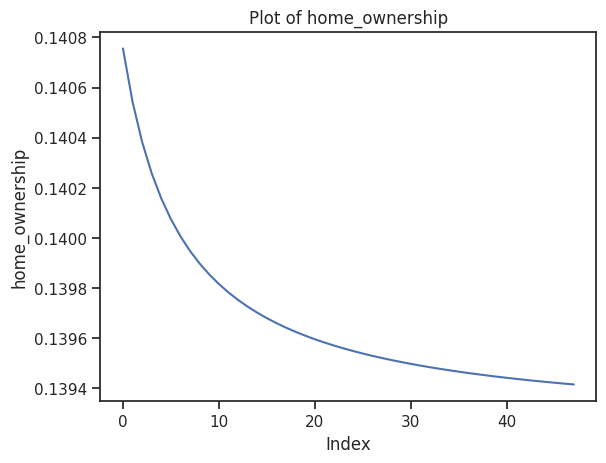

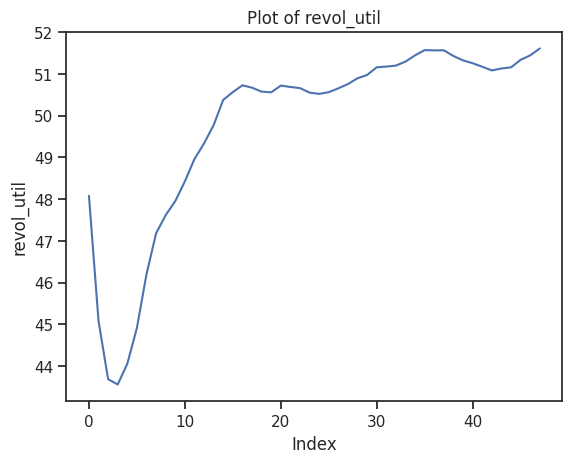

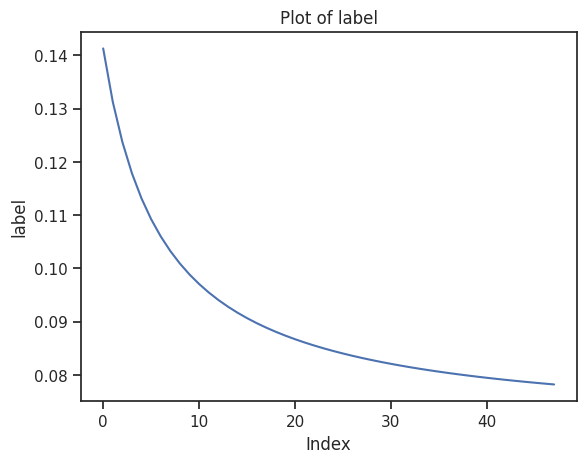

In [163]:
# Assuming 'df' is your DataFrame
for column in mean_df.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(mean_df[column])  # Plot the column data
    plt.title(f'Plot of {column}')  # Title with the name of the column
    plt.xlabel('Index')  # X-axis label, adjust if your index has specific meaning, e.g., 'Time' or 'Date'
    plt.ylabel(column)  # Y-axis label using the column name

    # Display the plot
    plt.show()
